## Deep Learning Project


Course: CIS 62<br>
Professor: Angel Hernandez<br>
Student: Jack Chen<br>
<br>
Purpose:<br>
- hello world
<br>

Details:<br>
1. Load libraries, data cleaning<br>
2. Exploratory Data Analysis (EDA)<br>
3. Deep Learning<br>
4. Conclusion<br>
5. References<br>

## Libraries, Functions, Load/Cleaning Data

### Load Libraries

In [42]:
# Parsing
import requests
from bs4 import BeautifulSoup
# Alpha Vantage API - stock data
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from alpha_vantage.techindicators import TechIndicators

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

# Deep Learning
import tensorflow
import keras.layers

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Model Featuring
from keras.layers import Input, Flatten, Dense, Activation, LeakyReLU, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor


# Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from keras import Sequential, Model

# Analyze Results
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score

# Misc
# filter warnings
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History   
import warnings
warnings.filterwarnings("ignore")
import pickle

### Functions

In [2]:
# Function to clean balance sheet df
def convMonth(x):
    if x == 'MAR':
        x = 3
    elif x == 'DEC':
        x = 12
    elif x =='JUN':
        x = 6
    elif x == 'SEP':
        x = 9
    return x

In [3]:
# Function - ML - run machine learning model and print out MSE
def runML(model,feature,target,ftest,ttest):
    model.fit(feature, target)
    print(model)
    print('MAE for training:', mean_absolute_error(target,model.predict(feature)))
    print('MAE for testing:', mean_absolute_error(ttest,model.predict(ftest)))
    print('R2 score:', model.score(ftest,ttest))
    print('')

In [4]:
# Convert to sequence function for TimeSeries to seq models 
def convSeq(feature, target, seq):
    Xs, ys = [],[]
    
    # from 0 to (len - seq)
    for i in range(len(feature) - seq):

        # from i to (i + seq)
        v = feature.iloc[i:(i+seq)]
        Xs.append(v)

        # target of (i+seq)
        ys.append(target.iloc[i+seq])
    return np.array(Xs), np.array(ys)

In [5]:
# Convert sequence dimenstions
def convDim(feature, target):
    targetArray = np.array(target)
    targetNew = targetArray.reshape(-1,1)
    featureArray = np.array(feature)
    featureNew = featureArray.reshape(featureArray.shape[0], featureArray.shape[1], 1)
    return featureNew, targetNew

In [31]:
# didnt work...

def hyperLSTM(units=32,activation='relu',optimizer='adam'):
    x=Xt
    ls = Sequential()
    ls.add(LSTM(units=32,activation=activation,return_sequences=True,input_shape=(x[1],x[2])))
    ls.add(LSTM(units=32/2, activation=activation, input_shape=(x[1],units)))
    ls.add(Dense(units=3, activation = activation))
    ls.add(Dense(units=1, activation = activation))
    ls.compile(optimizer=optimizer, loss='mse',metrics=['mse','mae'])
    return ls



### AlphaVantage API

In [ ]:
# Variable - store Alpha Vantage API key
# path =  r'C:\Users\Gumo\Desktop\Git\Notebook\keys\alphaVantage.txt'
# with open(path, mode='r') as w:
#     key = (w.readline())

In [ ]:
# URL Method
# def alpha(function, symbol):
#     url = 'https://www.alphavantage.co/query?function='+function+'&symbol='+symbol+'&apikey='+key
#     response = requests.get(url)

# Function AlphaVantage
def alpha(symbol, function, period=None, typ = None, tim=None):
    
    # Funciton - TimeSeries
    if function == 't':
        # Instance - TimeSeries Instance
        ts = TimeSeries(key = key, output_format='pandas')
        if period == 'd':
            data = ts.get_daily_adjusted(symbol, outputsize=outputsize)[0]
        elif period == 'w':
            data = ts.get_weekly_adjusted(symbol)[0]
        elif period == 'm':
            data = ts.get_monthly_adjusted(symbol)[0]

    # Funciton - FundamentalData
    elif function == 'f':
        # Instance - FundamentalData Instance
        fd = FundamentalData(key, output_format='pandas')
        if period == 'q':
            if typ == 'i':
                data = fd.get_income_statement_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
        elif period =='a':
            if typ == 'i':
                data = fd.get_income_statement_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
    
    # Funciton - TechnicalIndicator            
    elif function =='ti':
        ti = TechIndicators(key,output_format='pandas')

        # reassign period into TI format
        if period == 'm':
            period = 'monthly'
        elif period =='w':
            period = 'weekly'
        elif period == 'd':
            period ='daily'

        if typ == 'rsi':
            data=ti.get_rsi(symbol,interval=period,time_period=tim,series_type='close')[0]
        elif typ =='so':
            data = ti.get_stoch(symbol,interval=period)[0]
            
    # Funciton - CC
    elif function == 'c':
        # Instance - Crypto
        cc = CryptoCurrencies(key, output_format='pandas')
        pass
    return data

In [ ]:
# Variable Size
outputsize = 'compact'

# Variable Stock
symbol = 'cvx'

# Variable Function - t, f, c, ti (timeseries, financialdata, crypto, technical indicator)
function = 'ti'

# Variable Period
# TimeSeries: d,w,m,i (daily, weekly, monthly, interval(mins))
# Fundamental: q,a (quarterly,annually)
# Technical: d,w,m, (interval(mins))
period = 'm'

# Varible - Type
# Fundamental: i,b,c
# Technical: so,rsi
typ ='so'

# Varible - Time
tim = 60

info = alpha(symbol,function,period=period,typ = typ,tim=tim)
info.head()

In [ ]:
# save to local stock data
# info.to_csv('data/'+symbol.upper()+'stockPrice.csv')

### BeautifulSoup

In [ ]:
# Define a variable for the url of the site
site = "https://www.usinflationcalculator.com/inflation/current-inflation-rates/#:~:text=The%20annual%20inflation%20rate%20for,at%208%3A30%20a.m.%20ET"

In [ ]:
# Making a get request and assign the result to a variable response
response = requests.get(site)

#Check that the response was processed correctly
response.status_code

200

In [ ]:
# Extracting the HTML
#assign a variable html to response content.
html = response.content

# Checking that the reply is indeed an HTML code by inspecting the first 200 symbols
html[:200]

b'<!DOCTYPE html>\n<!--[if IE 7]>\n<html class="ie ie7" dir="ltr" lang="en-US"\n\tprefix="og: https://ogp.me/ns#" >\n<![endif]-->\n<!--[if IE 8]>\n<html class="ie ie8" dir="ltr" lang="en-US"\n\tprefix="og: https'

In [ ]:
#Convert HTML to a BeautifulSoup object, using the default parser of html  
#Create a BeautifulSoup object and store it in a variable named soup.
soup = BeautifulSoup(html, "html.parser")

In [ ]:
# The soup variable (BeautifulSoup object) we defined earlier can be seen as representing the whole document
soup

<!DOCTYPE html>

<!--[if IE 7]>
<html class="ie ie7" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if IE 8]>
<html class="ie ie8" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if !(IE 7) | !(IE 8) ]><!-->
<html dir="ltr" lang="en-US" prefix="og: https://ogp.me/ns#">
<!--<![endif]-->
<head>
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-2181571-7"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-2181571-7');
</script>
<meta charset="utf-8"/>
<meta content="width=device-width" name="viewport"/>
<link href="http://gmpg.org/xfn/11" rel="profile"/>
<link href="https://www.usinflationcalculator.com/xmlrpc.php" rel="pingback"/>
<!--[if lt IE 9]>
	<script src="https://www.usinflationcalculator.com/wp-content/themes/twentyfourteen/js/html5.js"></script>


In [ ]:
#using prettify() method to turn a Beautiful Soup parse tree into a nicely formatted Unicode string,
#with a separate line for each tag and each string:
print(soup.prettify())

<!DOCTYPE html>
<!--[if IE 7]>
<html class="ie ie7" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if IE 8]>
<html class="ie ie8" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if !(IE 7) | !(IE 8) ]><!-->
<html dir="ltr" lang="en-US" prefix="og: https://ogp.me/ns#">
 <!--<![endif]-->
 <head>
  <!-- Global site tag (gtag.js) - Google Analytics -->
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-2181571-7">
  </script>
  <script>
   window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-2181571-7');
  </script>
  <meta charset="utf-8"/>
  <meta content="width=device-width" name="viewport"/>
  <link href="http://gmpg.org/xfn/11" rel="profile"/>
  <link href="https://www.usinflationcalculator.com/xmlrpc.php" rel="pingback"/>
  <!--[if lt IE 9]>
	<script src="https://www.usinflationcalculator.com/wp-content/themes/twentyfourteen/

In [ ]:
# Exporting the HTML to a file
with open('output/inflation_rate_response.html', 'wb') as file:
    file.write(soup.prettify('utf-8'))

In [ ]:
# creating list with all tables
tables = soup.find_all('table')

In [ ]:
# Inspect the value of the variable
tables

[<table cellpadding="0" cellspacing="0" width="110%">
 <tr height="17">
 <td align="right" height="17"><strong>Year</strong></td>
 <td align="right"><strong>Jan</strong></td>
 <td align="right"><strong>Feb</strong></td>
 <td align="right"><strong>Mar</strong></td>
 <td align="right"><strong>Apr</strong></td>
 <td align="right"><strong>May</strong></td>
 <td align="right"><strong>Jun</strong></td>
 <td align="right"><strong>Jul</strong></td>
 <td align="right"><strong>Aug</strong></td>
 <td align="right"><strong>Sep</strong></td>
 <td align="right"><strong>Oct</strong></td>
 <td align="right"><strong>Nov</strong></td>
 <td align="right"><strong>Dec</strong></td>
 <td align="right"><strong>Ave</strong></td>
 </tr>
 <tr>
 <td align="right" height="17"><strong>2022</strong></td>
 <td align="right">7.5</td>
 <td align="right">7.9</td>
 <td align="right">8.5</td>
 <td align="right">8.3</td>
 <td align="right"><em>Avail.<br/>
      June<br/>
      10</em></td>
 <td align="right"> </td>
 <td a

In [ ]:
#since there is only one table, set table as the first table in tables
table = tables[0]
#display table
table

<table cellpadding="0" cellspacing="0" width="110%">
<tr height="17">
<td align="right" height="17"><strong>Year</strong></td>
<td align="right"><strong>Jan</strong></td>
<td align="right"><strong>Feb</strong></td>
<td align="right"><strong>Mar</strong></td>
<td align="right"><strong>Apr</strong></td>
<td align="right"><strong>May</strong></td>
<td align="right"><strong>Jun</strong></td>
<td align="right"><strong>Jul</strong></td>
<td align="right"><strong>Aug</strong></td>
<td align="right"><strong>Sep</strong></td>
<td align="right"><strong>Oct</strong></td>
<td align="right"><strong>Nov</strong></td>
<td align="right"><strong>Dec</strong></td>
<td align="right"><strong>Ave</strong></td>
</tr>
<tr>
<td align="right" height="17"><strong>2022</strong></td>
<td align="right">7.5</td>
<td align="right">7.9</td>
<td align="right">8.5</td>
<td align="right">8.3</td>
<td align="right"><em>Avail.<br/>
     June<br/>
     10</em></td>
<td align="right"> </td>
<td align="right"> </td>
<td alig

In [ ]:
# extracting all rows
table.find_all('tr')

[<tr height="17">
 <td align="right" height="17"><strong>Year</strong></td>
 <td align="right"><strong>Jan</strong></td>
 <td align="right"><strong>Feb</strong></td>
 <td align="right"><strong>Mar</strong></td>
 <td align="right"><strong>Apr</strong></td>
 <td align="right"><strong>May</strong></td>
 <td align="right"><strong>Jun</strong></td>
 <td align="right"><strong>Jul</strong></td>
 <td align="right"><strong>Aug</strong></td>
 <td align="right"><strong>Sep</strong></td>
 <td align="right"><strong>Oct</strong></td>
 <td align="right"><strong>Nov</strong></td>
 <td align="right"><strong>Dec</strong></td>
 <td align="right"><strong>Ave</strong></td>
 </tr>, <tr>
 <td align="right" height="17"><strong>2022</strong></td>
 <td align="right">7.5</td>
 <td align="right">7.9</td>
 <td align="right">8.5</td>
 <td align="right">8.3</td>
 <td align="right"><em>Avail.<br/>
      June<br/>
      10</em></td>
 <td align="right"> </td>
 <td align="right"> </td>
 <td align="right"> </td>
 <td ali

In [ ]:
#Gets all the column headers of our table
#create an empty list name it headers
headers = []
#loop through the first row which containts the header names
#save the text in the table header tag after stripping any extra spaces as title
#append this title to the headers list
for i in table.find_all('tr')[0]:
    title = i.text.strip()
    if title != '':
        headers.append(title)
        
#display headers in a list
headers

In [ ]:
#Creates a dataframe using the column headers from our table
df = pd.DataFrame(columns = headers)

#display the header in a dataframe
df

In [ ]:
#create a for loop to iterate all the rows in the table
#retrieve the text in the row which is the value we want
#get the length of the dataframe
#populate the contents of the dataframe iteratively by reading each row 
#increment the length of the dataframe and add the row to the end of the dataframe
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    length = len(df)
    df.loc[length] = row

In [ ]:
#display the dataframe
df.head()

In [ ]:
# set year, month and inflaiton rate as the column name and remove unneeded value
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_inflation = pd.melt(df, id_vars = 'Year', value_vars=months,var_name='Month', value_name='Inflation Rate')
df_inflation['Month']=pd.Categorical(df_inflation['Month'], categories=months, ordered=True)
df_inflation.sort_values(by=['Year','Month'], inplace=True)

In [ ]:
# display the head of the dataframe
df_inflation.head()

In [ ]:
# save it to a csv file
df_inflation.to_csv('data/inflation_rate_clean.csv')

### Load/Clean Data

In [6]:
# load dfs - data will be 01/2000 to 03/2022, 22 years and 3 month is 267 month, 
df_bs = pd.read_excel('data/df_cvx_bs_quarter.xlsx', engine='openpyxl')
df_is = pd.read_excel('data/df_cvx_is_quarter.xlsx', engine='openpyxl')
df_stock = pd.read_csv('data/CVXstockPrice.csv')
df_inflation = pd.read_csv('data/clean_inflation_rate.csv')
df_gas = pd.read_excel('data/gasPrices.xlsx', engine='openpyxl')

Stcok DF

In [7]:
# we just need adjusted close , volumn
dfstock1 = df_stock.iloc[:,[0,5,6]]

# create year column and month column
dfstock1['year'] = df_stock.date.apply(lambda x : x.split('-')[0])
dfstock1['month'] = df_stock.date.apply(lambda x : x.split('-')[1])
dfstock1.tail()

# drop useless columns
dfstock2 = dfstock1.iloc[2:-1,1:]
# reset index
dfstock3 = dfstock2.reset_index(drop=True)

# convert month into int
dfstock3.month = dfstock3.month.apply(lambda x: int(x))

#assign to finaldf
dfstockf = dfstock3.sort_values(by=['year','month'])
dfstockf

,5. adjusted close,6. volume,year,month
266,18.2953,37687500.0,2000,1
265,16.4760,42961800.0,2000,2
264,20.3915,51176100.0,2000,3
263,18.7790,31502600.0,2000,4
262,20.5234,30692800.0,2000,5
...,...,...,...,...
4,110.7529,224686287.0,2021,11
3,115.1489,221128758.0,2021,12
2,128.8667,300049707.0,2022,1
1,142.7935,282783725.0,2022,2


Balance Sheet DF

In [8]:
# df_BalanceSheet - Clean Balance Sheet
# transpose df
df_bs1 = df_bs.T

# assign column names
df_bs1.columns = df_bs1.iloc[0,:]

# reset index and drop first row
df_bs2 = df_bs1.reset_index().iloc[1:,:]
df_bs2.head(3)

Unnamed: 0,index,Cash & Short-Term Investments,Cash Only,Total Short Term Investments,Short-Term Receivables,"Accounts Receivables, Net","Accounts Receivables, Gross",Bad Debt/Doubtful Accounts,Other Receivables,Inventories,...,Other Appropriated Reserves,Treasury Stock,Repurchased Stock Value,Total Shareholders' Equity,Accumulated Minority Interest,Total Equity,Total Liabilities & Shareholders' Equity,Per Share,Book Value per Share,Tangible Book Value per Share
1,MAR '22,12.02,11.99,0.03,23.26,23.2,23.51,-0.3,0.05,6.53,...,-3.71,-39.16,1.25,146.22,0.88,147.1,249.05,NaN,74.42,72.19
2,DEC '21,6.01,5.97,0.04,18.42,18.17,18.47,-0.3,0.25,6.31,...,-3.96,-41.46,0.75,139.07,0.87,139.94,239.54,NaN,72.06,69.79
3,SEP '21,6.28,6.24,0.03,16.57,16.16,16.45,-0.29,0.4,6.13,...,-4.51,-41.42,0.63,135.86,0.86,136.72,239.95,NaN,70.48,68.2


In [9]:
# see the columns
df_bs2.columns

Index(['index', 'Cash & Short-Term Investments', 'Cash Only',
       'Total Short Term Investments', 'Short-Term Receivables',
       'Accounts Receivables, Net', 'Accounts Receivables, Gross',
       'Bad Debt/Doubtful Accounts', 'Other Receivables', 'Inventories',
       'Finished Goods', 'Raw Materials', 'Other Current Assets',
       'Miscellaneous Current Assets', 'Total Current Assets',
       'Net Property, Plant & Equipment',
       'Property, Plant & Equipment - Gross',
       'Operating Lease Right-of-Use Assets', 'Accumulated Depreciation',
       'Total Long-Term Investments ', 'LT Investment - Affiliate Companies',
       'Other Long-Term Investments', 'Long-Term Note Receivable',
       'Intangible Assets', 'Goodwill', 'Deferred Tax Assets', 'Other Assets',
       'Tangible Other Assets', 'Total Assets',
       'Liabilities & Shareholders' Equity', 'ST Debt & Curr. Portion LT Debt',
       'Accounts Payable', 'Income Tax Payable', 'Other Current Liabilities',
       'Misc

In [10]:
# select the needed columns
df_bs3 = df_bs2[['index','Total Assets', 'Total Equity']].iloc[:89,:]
df_bs3.shape

(89, 3)

In [11]:
# since data is quarterly, we will append the data until we have 267 month
dfbs4 = df_bs3
dfbs5 = dfbs4.append(df_bs3)
dfbs6 = dfbs5.append(df_bs3)
dfbs6.shape

(267, 3)

In [17]:
# convert year and month
dfbs6['year'] = dfbs6['index'].apply(lambda x : int(x.split(' \'')[1]) + 2000)
dfbs6['month'] = dfbs6['index'].apply(lambda x : convMonth(x.split(' \'')[0]))
dfbs6.head()

Unnamed: 0,index,Total Assets,Total Equity,year,month
1,MAR '22,249.05,147.1,2022,3
2,DEC '21,239.54,139.94,2021,12
3,SEP '21,239.95,136.72,2021,9
4,JUN '21,242.81,133.91,2021,6
5,MAR '21,241.65,132.93,2021,3


In [18]:
dfbsf = dfbs6.sort_values(by=['year','month'])
dfbsf.shape

(267, 5)

Income Statement DF

In [19]:
# Income Statement - Clean Balance Sheet
# transpose df
df_is1 = df_is.T

# assign column names
df_is1.columns = df_is1.iloc[0,:]

# reset index and drop first row
df_is2 = df_is1.reset_index().iloc[1:,:]
df_is2.head(3)

Unnamed: 0,index,Sales,Cost of Goods Sold (COGS) incl. D&A,COGS excluding D&A,Depreciation & Amortization Expense,Depreciation,Gross Income,SG&A Expense,Other SG&A,Other Operating Expense,...,EPS (diluted),Diluted Shares Outstanding,Total Shares Outstanding,Earnings Persistence,Dividends per Share,Payout Ratio,EBITDA,EBITDA,EBIT,Depreciation & Amortization Expense
1,MAR '22,53187.0,42045.0,38256.0,3789.0,3789.0,11142.0,1031.0,1031.0,2002.0,...,3.2188,1944.542,1964.813456,89.786,1.42,44.11582,NaN,11898.0,8109.0,3789.0
2,DEC '21,46207.0,37420.0,32958.0,4462.0,4462.0,8787.0,1357.0,1357.0,1779.0,...,2.63,1922.082,1929.806057,89.972,1.34,50.95057,NaN,10113.0,5651.0,4462.0
3,SEP '21,42349.0,33628.0,29288.0,4340.0,4340.0,8721.0,757.0,757.0,2075.0,...,3.181,1921.095,1927.685919,89.344,1.34,42.125118,NaN,10229.0,5889.0,4340.0


In [20]:
# see the columns
df_is2.columns

Index(['index', 'Sales', 'Cost of Goods Sold (COGS) incl. D&A',
       'COGS excluding D&A', 'Depreciation & Amortization Expense',
       'Depreciation', 'Gross Income', 'SG&A Expense', 'Other SG&A',
       'Other Operating Expense', 'EBIT (Operating Income)',
       'Nonoperating Income - Net', 'Equity in Earnings of Affiliates',
       'Other Income (Expense)', 'Interest Expense', 'Gross Interest Expense',
       'Interest Capitalized', 'Unusual Expense - Net', 'Impairments',
       'Property,Plant & Equipment', 'Financial Fixed Assets',
       'Restructuring Expense', 'Unrealized Valuation Gain/Loss',
       'Hedges/Derivatives', 'Excpl Chrgs - Others', 'Calamitous Events',
       'Pretax Income', 'Income Taxes', 'Equity in Earnings of Affiliates',
       'Consolidated Net Income', 'Minority Interest', 'Net Income',
       'Discontinued Operations', 'Net Income available to Common',
       'Per Share', 'EPS (recurring)', 'Basic Shares Outstanding',
       'Total Shares Outstanding'

In [21]:
# select needed columns
df_is3 = df_is2[['index','Sales','Net Income']].iloc[:89,:]
df_is3.shape

(89, 3)

In [22]:
# append df to 267 month
dfis4 = df_is3
dfis5 = dfis4.append(df_is3)
dfis6 = dfis5.append(df_is3)


In [23]:
# 22 year 3 month = 267 month
dfis6.shape

(267, 3)

In [24]:
# create year and month columns
dfis6['year'] = dfis6['index'].apply(lambda x : int(x.split(' \'')[1]) + 2000)
dfis6['month'] = dfis6['index'].apply(lambda x : convMonth(x.split(' \'')[0]))
dfis6.head()

Unnamed: 0,index,Sales,Net Income,year,month
1,MAR '22,53187.0,6259.0,2022,3
2,DEC '21,46207.0,5055.0,2021,12
3,SEP '21,42349.0,6111.0,2021,9
4,JUN '21,36385.0,3082.0,2021,6
5,MAR '21,31350.0,1377.0,2021,3


In [25]:
# sort by values
dfisf = dfis6.sort_values(by=['year','month'])
dfisf.shape

(267, 5)

Inflation DF

In [26]:
# format inflation df
dfi1 = df_inflation.iloc[:267,:]
dfi1

,Unnamed: 0,Year,Month,Inflation Rate
0,22,2000,Jan,2.7
1,45,2000,Feb,3.2
2,68,2000,Mar,3.8
3,91,2000,Apr,3.1
4,114,2000,May,3.2
...,...,...,...,...
262,231,2021,Nov,6.8
263,254,2021,Dec,7.0
264,0,2022,Jan,7.5
265,23,2022,Feb,7.9


Gas DF

In [27]:
df_gas.Date = df_gas.Date.astype(str)

In [28]:
df_gas['year'] = df_gas.Date.apply(lambda x : x.split('-')[0])
df_gas['month'] = df_gas.Date.apply(lambda x : x.split('-')[1])
df_gas

,Date,U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon),year,month
0,1993-04-15,1.078,1993,04
1,1993-05-15,1.100,1993,05
2,1993-06-15,1.097,1993,06
3,1993-07-15,1.078,1993,07
4,1993-08-15,1.062,1993,08
...,...,...,...,...
343,2021-11-15,3.491,2021,11
344,2021-12-15,3.406,2021,12
345,2022-01-15,3.413,2022,01
346,2022-02-15,3.611,2022,02


In [29]:
# get dfgas1
dfgas1 = df_gas.iloc[81:,:]

In [30]:
# create merged df
dfmerge = dfstockf

#rewrite quartly month into 12 month
dfmerge['sales'] = list(dfisf.Sales)
dfmerge['netIncome'] = list(dfisf['Net Income'])
dfmerge['Total Assets'] = list(dfbsf['Total Assets'])
dfmerge['Total Equity'] = list(dfbsf['Total Equity'])
dfmerge['inflation'] = list(dfi1['Inflation Rate'])
dfmerge['gas'] = list(dfgas1['U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)'])

# create the dfmerge1 reset index, rename columns
dfmerge1 = dfmerge.reset_index(drop=True).rename(columns={'5. adjusted close':'adjustedClose','6. volume':'volume','Total Assets': 'assets','Total Equity': 'equity'})

''' Units
sales - millions
netIncome - millions
asset - billions
equity - billions

'''

# assign new df
dfmerge2 = dfmerge1

# convert into millions
dfmerge2.equity = dfmerge1.equity * 1000
dfmerge2.assets = dfmerge1.assets * 1000
# convert into 3 month average
dfmerge2.sales = dfmerge1.sales/3
dfmerge2.netIncome = dfmerge1.netIncome/3
dfmerge2.year = dfmerge2.year.astype(int)
dfmerge2.inflation = dfmerge2.inflation.astype(float)

In [31]:
dfmerge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   adjustedClose  267 non-null    float64
 1   volume         267 non-null    float64
 2   year           267 non-null    int32  
 3   month          267 non-null    int64  
 4   sales          267 non-null    float64
 5   netIncome      267 non-null    float64
 6   assets         267 non-null    float64
 7   equity         267 non-null    float64
 8   inflation      267 non-null    float64
 9   gas            267 non-null    float64
dtypes: float64(8), int32(1), int64(1)
memory usage: 19.9 KB


In [ ]:
# dfmerge2.to_csv('data/final_df.csv')

## Exploratory Data Analysis (EDA)

## Machine Learning


### Load Data / Features

In [46]:
# load final df
dfmerge3 = pd.read_csv('data/final_df.csv',index_col=0)

# conversions
dfmerge4 = dfmerge3
dfmerge4.year = dfmerge3.year.astype(float)
dfmerge4.month = dfmerge3.month.astype(float)
dfmerge4.volume = dfmerge3.volume/1000000
dffinal = dfmerge4
dffinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 0 to 266
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   adjustedClose  267 non-null    float64
 1   volume         267 non-null    float64
 2   year           267 non-null    float64
 3   month          267 non-null    float64
 4   sales          267 non-null    float64
 5   netIncome      267 non-null    float64
 6   assets         267 non-null    float64
 7   equity         267 non-null    float64
 8   inflation      267 non-null    float64
 9   gas            267 non-null    float64
dtypes: float64(10)
memory usage: 22.9 KB


In [7]:
############################## MANUAL Train Test Split ##############################
# Since this is Time Series, we need split manually
# calculate train_size and test_size
train_size = int(len(dffinal)*0.8)
test_size = len(dffinal)-train_size

# split df 
traindf, testdf = dffinal.iloc[0:train_size], dffinal.iloc[train_size:]

# columns needed
featureColumns = ['volume','netIncome','equity','inflation','gas']
targetColumns = ['adjustedClose']

# Since data has wide range, apply Standard Scale
# X Scaler
featureScaler = StandardScaler()
X_train = traindf[featureColumns] = featureScaler.fit_transform(traindf[featureColumns].to_numpy())
X_test = testdf[featureColumns] = featureScaler.transform(testdf[featureColumns].to_numpy())

# y Scaler
targetScaler = StandardScaler()
y_train = traindf[targetColumns] = targetScaler.fit_transform(traindf[targetColumns])
y_test = testdf[targetColumns] = targetScaler.transform(testdf[targetColumns])



In [8]:
# Convert dimension for LSTM
Xt, yt = convSeq(traindf[featureColumns], traindf[targetColumns],6)

Xv, yv = convSeq(testdf[featureColumns], testdf[targetColumns] ,6)

print(X_train.shape)
print(Xt.shape)

(213, 5)
(207, 6, 5)


### Machine Learning

In [8]:
# initialize Model Instance
linear = LinearRegression()
ridge = Ridge()
randomForest = RandomForestRegressor()
xgb = XGBRegressor()


In [9]:
# run machine learning function
runML(linear, XtrainScale, ytrainScale,XtestScale,ytestScale)
runML(ridge, XtrainScale, ytrainScale,XtestScale,ytestScale)
runML(randomForest, XtrainScale, ytrainScale,XtestScale,ytestScale)
runML(xgb, XtrainScale, ytrainScale,XtestScale,ytestScale)

LinearRegression()
MAE for training: 0.15748245582624198
MAE for testing: 0.7936874991432176
R2 score: -0.9270052638491646

Ridge()
MAE for training: 0.15687002112127976
MAE for testing: 0.8091167787851973
R2 score: -0.9918835839237421

RandomForestRegressor()
MAE for training: 0.034613908318751885
MAE for testing: 0.8373390455017224
R2 score: -1.596280516355225

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random

Text(0, 0.5, 'Predicted Price')

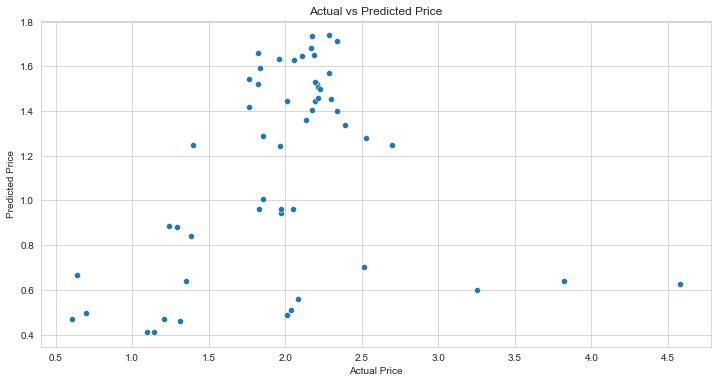

In [10]:
# Since XGB performs best, use xgb calculate y_predict
ypredict = xgb.predict(XtestScale)

a = []
for i in ytestScale:
    a.append(float(i))

# graph it
plt.figure(figsize=(12,6))
sns.scatterplot(x=np.array(a),y=ypredict)
plt.title('Actual vs Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')


### Deep Learning

#### ANN

In [9]:
# since ANN takes two dimension, we use X_train
# Features and optimizers
optimizer = 'rmsprop'

# Model
ann = Sequential()

# Hidden layer 1
ann.add(Flatten(input_shape= (traindf[featureColumns].shape[1], 1)))
ann.add(Dense(16))
ann.add(LeakyReLU(alpha=0.05))

# Hidden layer 2
ann.add(Dense(4))
ann.add(LeakyReLU(alpha=0.05))

# output layer
ann.add(Dense(1))

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
ann.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae'])

# model summary
ann.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 16)                96        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable pa

In [10]:
# model fit
history = ann.fit(traindf[featureColumns], traindf[targetColumns], epochs=50, batch_size=2, validation_data=(testdf[featureColumns], testdf[targetColumns]),verbose=1)

Epoch 1/50
107/107 [==============================] - 1s 3ms/step - loss: 0.6375 - mse: 0.6375 - mae: 0.6607 - val_loss: 4.9617 - val_mse: 4.9617 - val_mae: 2.0989
Epoch 2/50
107/107 [==============================] - 0s 1ms/step - loss: 0.3719 - mse: 0.3719 - mae: 0.4479 - val_loss: 4.1841 - val_mse: 4.1841 - val_mae: 1.8980
Epoch 3/50
107/107 [==============================] - 0s 1ms/step - loss: 0.2143 - mse: 0.2143 - mae: 0.3230 - val_loss: 3.1852 - val_mse: 3.1852 - val_mae: 1.6096
Epoch 4/50
107/107 [==============================] - 0s 1ms/step - loss: 0.1108 - mse: 0.1108 - mae: 0.2409 - val_loss: 2.2049 - val_mse: 2.2049 - val_mae: 1.2797
Epoch 5/50
107/107 [==============================] - 0s 1ms/step - loss: 0.0614 - mse: 0.0614 - mae: 0.1873 - val_loss: 1.7374 - val_mse: 1.7374 - val_mae: 1.0801
Epoch 6/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1592 - val_loss: 1.4403 - val_mse: 1.4403 - val_mae: 0.9580
Epoch 7/50
107/1

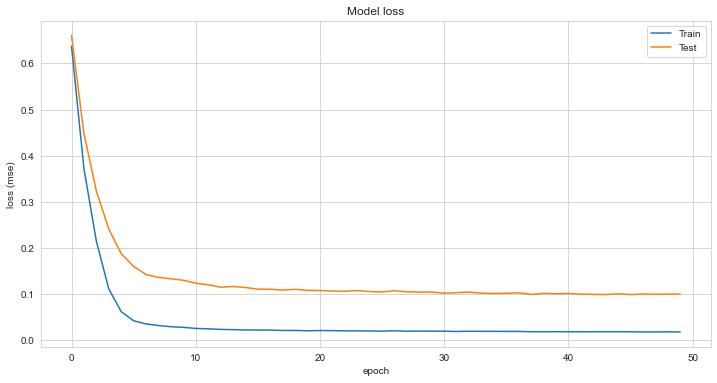

In [11]:
plt.figure(figsize=(12,6))
plt.plot(ann.history.history['loss'][:])
plt.plot(ann.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

In [66]:
# NN - this model takes in 3 dimension
inputs = Input(shape=(Xt.shape[1], Xt.shape[2]))
x = Flatten()(inputs)
x = Dense(16, activation=LeakyReLU(alpha=0.05))(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.summary()

model.compile(optimizer=optimizer, loss="mse", metrics=['mse',"mae"])
history = model.fit(Xt, yt, epochs=50)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6, 5)]            0         
                                                                 
 flatten_11 (Flatten)        (None, 30)                0         
                                                                 
 dense_45 (Dense)            (None, 16)                496       
                                                                 
 dense_46 (Dense)            (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 1.2901 - mse: 1.2901 - mae: 0.9883
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 0.8163 - mse: 0.

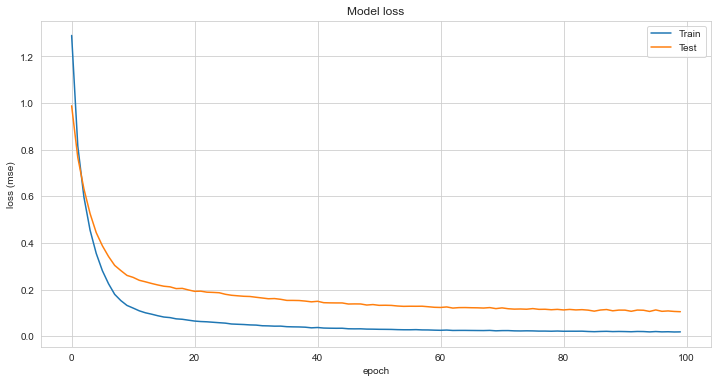

In [67]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

#### LSTM

In [44]:
optimizer = 'adam'

# Model
lstm = Sequential()

# # Hideen layers
lstm.add(LSTM(units=16,activation = LeakyReLU(alpha=0.05), return_sequences = True, input_shape= (Xt.shape[1], Xt.shape[2])))
lstm.add(LSTM(units=8,activation = LeakyReLU(alpha=0.05),input_shape= (Xt.shape[1], 16)))
lstm.add(Dense(units=3, activation = LeakyReLU(alpha=0.05)))
lstm.add(Dense(units=1, activation = LeakyReLU(alpha=0.05)))


######## Does not work if i try to save model) ########
# checkpoint = ModelCheckpoint('lstm.h5', monitor='mse', save_best_only=True, verbose=1)
# lstm.compile(optimizer=optimizer, loss='mse',metrics=['mse','mae'],callbacks=[checkpoint])




lstm.compile(optimizer=optimizer, loss='mse',metrics=['mse','mae'])
lstm.summary()
history = lstm.fit(Xt, yt, epochs=50, batch_size=2,verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 6, 16)             1408      
                                                                 
 lstm_11 (LSTM)              (None, 8)                 800       
                                                                 
 dense_13 (Dense)            (None, 3)                 27        
                                                                 
 dense_14 (Dense)            (None, 1)                 4         
                                                                 
Total params: 2,239
Trainable params: 2,239
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
104/104 [==============================] - 3s 5ms/step - loss: 0.8291 - mse: 0.8291 - mae: 0.7973
Epoch 2/50
104/104 [==============================] - 0s 4ms/step - loss: 0

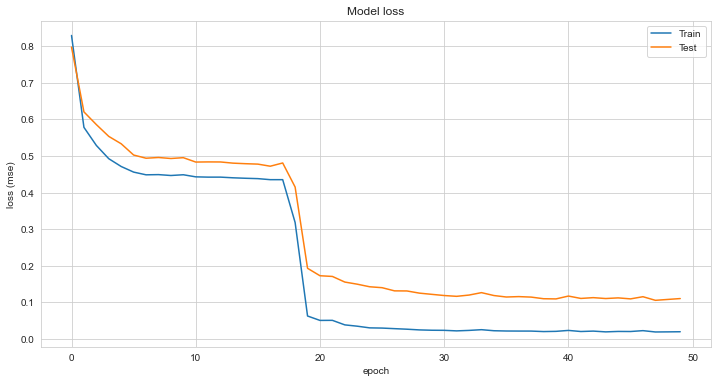

In [45]:
plt.figure(figsize=(12,6))
plt.plot(lstm.history.history['loss'][:])
plt.plot(lstm.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

In [18]:
inputs = Input(shape=(Xt.shape[1], Xt.shape[2]))
x = LSTM(16)(inputs)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=['mse',"mae"])
history = model.fit(Xt,yt,epochs=50)

Epoch 1/50
7/7 [==============================] - 2s 4ms/step - loss: 1.0655 - mse: 1.0655 - mae: 0.8866
Epoch 2/50
7/7 [==============================] - 0s 4ms/step - loss: 0.7549 - mse: 0.7549 - mae: 0.7471
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 0.5703 - mse: 0.5703 - mae: 0.6466
Epoch 4/50
7/7 [==============================] - 0s 3ms/step - loss: 0.4315 - mse: 0.4315 - mae: 0.5557
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 0.3270 - mse: 0.3270 - mae: 0.4718
Epoch 6/50
7/7 [==============================] - 0s 4ms/step - loss: 0.2477 - mse: 0.2477 - mae: 0.3988
Epoch 7/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1916 - mse: 0.1916 - mae: 0.3446
Epoch 8/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1488 - mse: 0.1488 - mae: 0.3000
Epoch 9/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1165 - mse: 0.1165 - mae: 0.2621
Epoch 10/50
7/7 [==============================] - 0s 4

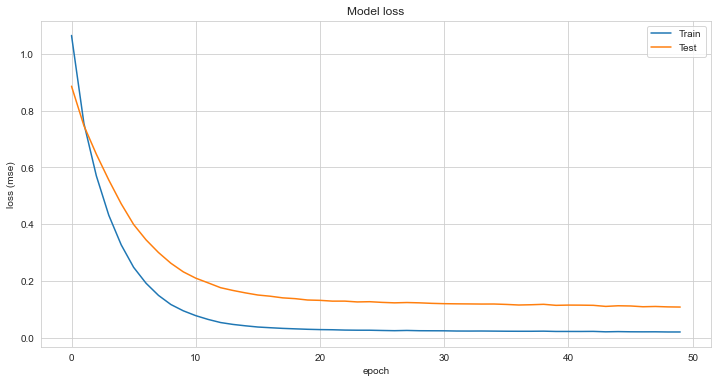

In [19]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

#### RNN Bidirectional LSTM

In [91]:
biLSTM = Sequential()

biLSTM.add(Bidirectional(LSTM(units=64,input_shape=(Xt[1],Xt[2]))))
biLSTM.add(Dense(units=32, activation='selu'))
biLSTM.add(Dense(units=16, activation='selu'))
biLSTM.add(Dense(units=8, activation='selu'))
biLSTM.add(Dense(units=1, activation='selu'))

biLSTM.compile(optimizer=optimizer, loss='mse', metrics=['mse','mae'])

# biLSTM.summary()

history = biLSTM.fit(Xt, yt, epochs=50, batch_size=2,verbose=1)

Epoch 1/50
104/104 [==============================] - 4s 4ms/step - loss: 0.1655 - mse: 0.1655 - mae: 0.3029
Epoch 2/50
104/104 [==============================] - 0s 3ms/step - loss: 0.0716 - mse: 0.0716 - mae: 0.2076
Epoch 3/50
104/104 [==============================] - 0s 4ms/step - loss: 0.0527 - mse: 0.0527 - mae: 0.1679
Epoch 4/50
104/104 [==============================] - 0s 4ms/step - loss: 0.0576 - mse: 0.0576 - mae: 0.1826
Epoch 5/50
104/104 [==============================] - 0s 3ms/step - loss: 0.0433 - mse: 0.0433 - mae: 0.1593
Epoch 6/50
104/104 [==============================] - 0s 3ms/step - loss: 0.0418 - mse: 0.0418 - mae: 0.1544
Epoch 7/50
104/104 [==============================] - 0s 4ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1535
Epoch 8/50
104/104 [==============================] - 0s 4ms/step - loss: 0.0390 - mse: 0.0390 - mae: 0.1509
Epoch 9/50
104/104 [==============================] - 0s 4ms/step - loss: 0.0292 - mse: 0.0292 - mae: 0.1289
Epoch 10/50
104/104

In [92]:
biLSTM.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 128)              35840     
 nal)                                                            
                                                                 
 dense_52 (Dense)            (None, 32)                4128      
                                                                 
 dense_53 (Dense)            (None, 16)                528       
                                                                 
 dense_54 (Dense)            (None, 8)                 136       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 40,641
Trainable params: 40,641
Non-trainable params: 0
_________________________________________________

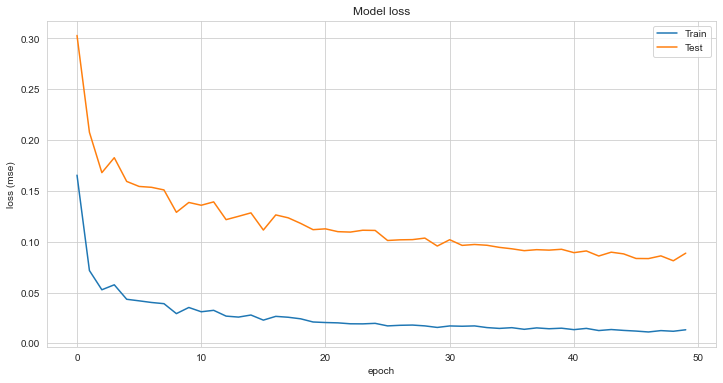

In [93]:
plt.figure(figsize=(12,6))
plt.plot(biLSTM.history.history['loss'][:])
plt.plot(biLSTM.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

#### Hyperparameters

In [41]:
def create_keras_model_to_find_optimizer(optimizer='adam'):
    # Model
    keras_model = Sequential()

    # Hidden layer 1
    keras_model.add(Flatten(input_shape= (traindf[featureColumns].shape[1], 1)))
    keras_model.add(Dense(16))
    keras_model.add(LeakyReLU(alpha=0.05))

    # Hidden layer 2
    keras_model.add(Dense(4))
    keras_model.add(LeakyReLU(alpha=0.05))

    # output layer
    keras_model.add(Dense(1))
    # Compile model
    keras_model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return keras_model
    
keras_model_02 = KerasClassifier(model=create_keras_model_to_find_optimizer, epochs=30, batch_size=2, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'GD', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=keras_model_02, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(Xt, yt)

ValueError: Unknown label type: continuous.

To implement support, subclass KerasClassifier and override ``target_encoder`` with a transformer that supports this label type.

For information on sklearn target types, see: * https://scikit-learn.org/stable/modules/generated/sklearn.utils.multiclass.type_of_target.html * https://scikit-learn.org/stable/modules/multiclass.html

For information on the SciKeras data transformation interface, see: * https://www.adriangb.com/scikeras/stable/advanced.html#data-transformers

In [34]:
ls_model = KerasClassifier(build_fn=hyperLSTM,verbose=1)
# units = [128, 64, 32, 16, 8]
# activation = ['selu', 'elu',LeakyReLU(alpha=0.05),'tanh','swish']
optimizer = ['SGD', 'GD', 'Adam', 'rmsprop']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=ls_model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(Xt, yt)

ValueError: Unknown label type: continuous.

To implement support, subclass KerasClassifier and override ``target_encoder`` with a transformer that supports this label type.

For information on sklearn target types, see: * https://scikit-learn.org/stable/modules/generated/sklearn.utils.multiclass.type_of_target.html * https://scikit-learn.org/stable/modules/multiclass.html

For information on the SciKeras data transformation interface, see: * https://www.adriangb.com/scikeras/stable/advanced.html#data-transformers

#### Predict

In [100]:
# y_predict using Bidirectional LSTM model
y_predict = biLSTM.predict(Xv)
yt_inverse = targetScaler.inverse_transform(yt.reshape(1,-1))
yv_inverse = targetScaler.inverse_transform(yv.reshape(1,-1))
y_predict_inv = targetScaler.inverse_transform(y_predict)

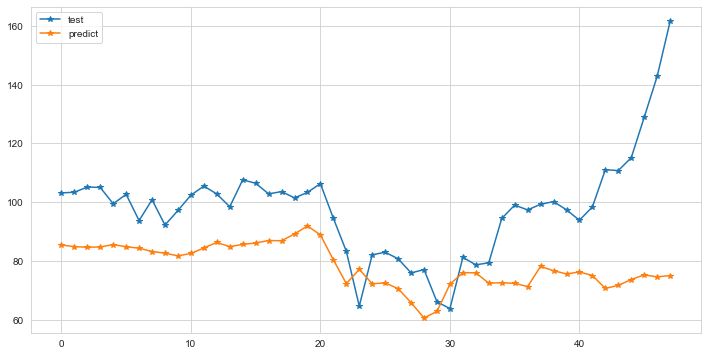

In [101]:
plt.figure(figsize=(12,6))
plt.plot(yv_inverse.flatten(),marker = '*', label='test')
plt.plot(y_predict_inv.flatten(),marker = '*', label='predict')
plt.legend()

## Conclusion


## References


----------
CIS43 Project Link<br>
https://colab.research.google.com/drive/1OS0i9lEitkL7PTE7TpLuWVoqkjS0BPYC
<br>

Load local file onto colab<br>
https://www.youtube.com/watch?v=6HFlwqK3oeo
<br>
<br>

----------
Inflation Data<br>
https://www.usinflationcalculator.com/inflation/current-inflation-rates/#:~:text=The%20annual%20inflation%20rate%20for,at%208%3A30%20a.m.%20ET.
<br>
<br>
Gas Prices<br>
https://www.kaggle.com/datasets/mruanova/us-gasoline-and-diesel-retail-prices-19952021
<br>
<br>